In [1]:
from pathlib import Path

while Path.cwd().name != 'ambient':
    %cd ..

/mmfs1/gscratch/xlab/alisaliu/ambient


In [2]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from generation.gpt3_generation import request
from utils.utils import sigmoid, predict_nli
from utils.constants import NLI_LABELS
import numpy as np
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

In [3]:
multilabel_model = RobertaForSequenceClassification.from_pretrained('models/roberta-large-wanli-multilabel').to('cuda')
tokenizer = RobertaTokenizer.from_pretrained('models/roberta-large-wanli-multilabel')

## detection

In [3]:
def paraphrase_gpt3(sentence, n, top_p=0.9, engine='text-davinci-003'):
    generations = set()
    for i in range(n):
        instruction = 'Paraphrase the text.'
        context = f'{instruction}\n\n{sentence}\nParaphrase: '
        generation = request(
            prompt=context,
            model=engine,
            top_p=top_p,
            n=1,
            stop=None,
            return_only_text=True
        )
        
        generation = generation.replace('Paraphrase:', '').strip()
        generations.add(generation)

    generations.discard('')
    generations.discard(sentence)
    return generations

In [5]:
claims_df = pd.read_json('data/claim-decomp/dev.jsonl', lines=True)

In [6]:
strings_to_remove = ['Says that', 'Says', '“', '"', '”', '(', ')']

claims_df['cleaned_claim'] = None
claims_df['ambiguity_score'] = None
claims_df['paraphrases'] = None
claims_df['paraphrases'] = claims_df['paraphrases'].astype('object')
for i, row in tqdm(claims_df.iterrows(), total=len(claims_df.index)):
    claim = row['claim']
    for s in strings_to_remove:
        claim = claim.replace(s, '')
    claim = claim.strip()
    claim = claim[0].upper() + claim[1:]
    paraphrases = paraphrase_gpt3(claim, n=5, engine='text-davinci-003', top_p=0.4)
    scores = []
    for paraphrase in paraphrases:
        probs = predict_nli(claim, paraphrase, multilabel_model, tokenizer)
        s = sorted([p for p in probs.values()], reverse=True)[1]
        scores.append(s)
    claims_df.at[i, 'cleaned_claim'] = claim
    claims_df.at[i, 'paraphrases'] = [(p,s) for p,s in zip(paraphrases, scores)]
    claims_df.at[i, 'ambiguity_score'] = np.nanmax(scores)

100%|██████████| 200/200 [14:31<00:00,  4.36s/it]


In [ ]:
claims_df.to_json('political-claims/results.jsonl', lines=True, orient='records')

## analysis

In [4]:
annotations = pd.read_csv('political-claims/dev-annotations.csv').drop('notes', axis=1)
claims_df = pd.read_json('political-claims/results.jsonl', lines=True)[['example_id', 'label', 'claim', 'cleaned_claim', 'ambiguity_score', 'paraphrases']]

In [5]:
results_df = claims_df.merge(annotations[['claim', 'annotation']], how='inner', on='claim')
results_df = results_df.drop('claim', axis=1).rename({'cleaned_claim': 'claim'}, axis=1)
results_df.head(3)

,example_id,label,claim,ambiguity_score,paraphrases,annotation
0,8057719209342304749,false,"With voting by mail, you get thousands and tho...",0.847081,"[[With voting by mail, people can fill out bal...",f
1,-3333998957238197422,barely-true,"I’ve already traveled to Washington, D.C., and...",0.094361,"[[I have already gone to Washington, D.C. and ...",f
2,-5816336384767541299,barely-true,When San Francisco banned plastic grocery bags...,0.018198,[[The number of people going to the ER with fo...,a


In [6]:
precisions = []
recalls = []
f1s = []
t = sigmoid(-1.97) # mean threshold tuned on AmbiEnt dev set from §5 (see Table 11)
y_pred = [1 if a > t else 0 for a in results_df.ambiguity_score]
y_true = [1 if a == 'a' else 0 for a in results_df.annotation]
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true, y_pred))

0.12403100775193798
0.8888888888888888
0.21768707482993196


{'contradiction': 0.007283803541213274, 'entailment': 0.9960212111473083, 'neutral': 0.1750793308019638}


/gscratch/cse/alisaliu/miniconda3/envs/nli/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


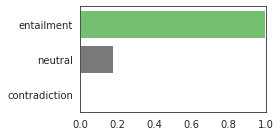

In [7]:
sns.set_style('white')
sns.set_palette('muted')
red = sns.color_palette('muted')[3]
green = sns.color_palette('muted')[2]
gray = sns.color_palette('muted')[-3]

premise = 'Donald Trump even said, on his very first day in office, he would require every school in America to let people carry guns into our classrooms.'
hypothesis = "Donald Trump said on his first day in office that every school in America would have to allow people to carry guns in classrooms."
probs = predict_nli(premise, hypothesis, multilabel_model, tokenizer)
print(probs)
x = list(probs.values())
fig, ax = plt.subplots(figsize=(4,2))
sns.barplot(x, NLI_LABELS, order=['entailment', 'neutral', 'contradiction'], palette=[green, gray, red])
ax.set_xlim(right=1)
plt.tight_layout()
plt.savefig('figures/multilabel_pred.png', dpi=300)